2025-07-18 15:36:28.732334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752852988.943096      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752852989.012539      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 19426 images belonging to 7 classes.
Found 5125 images belonging to 7 classes.


I0000 00:00:1752853014.092261      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1752853104.592681      72 service.cc:148] XLA service 0x7a3d08004160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752853104.593586      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752853113.947387      72 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752853165.914593      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


486/486 ━━━━━━━━━━━━━━━━━━━━ 745s 1s/step - accuracy: 0.1848 - loss: 3.4525 - precision: 0.2039 - recall: 0.0542 - val_accuracy: 0.2780 - val_loss: 2.2802 - val_precision: 0.2889 - val_recall: 0.0507 - learning_rate: 5.0000e-04
Epoch 2/60
486/486 ━━━━━━━━━━━━━━━━━━━━ 366s 753ms/step - accuracy: 0.2723 - loss: 2.8661 - precision: 0.3906 - recall: 0.0879 - val_accuracy: 0.2940 - val_loss: 2.1845 - val_precision: 0.3284 - val_recall: 0.0952 - learning_rate: 5.0000e-04
Epoch 3/60
486/486 ━━━━━━━━━━━━━━━━━━━━ 361s 743ms/step - accuracy: 0.3601 - loss: 2.5599 - precision: 0.5742 - recall: 0.1434 - val_accuracy: 0.2872 - val_loss: 2.7715 - val_precision: 0.3234 - val_recall: 0.1602 - learning_rate: 5.0000e-04
Epoch 4/60
486/486 ━━━━━━━━━━━━━━━━━━━━ 360s 741ms/step - accuracy: 0.4264 - loss: 2.3506 - precision: 0.6639 - recall: 0.2055 - val_accuracy: 0.4769 - val_loss: 1.7483 - val_precision: 0.6897 - val_recall: 0.2260 - learning_rate: 5.0000e-04
Epoch 5/60
486/486 ━━━━━━━━━━━━━━━━━━━━ 364s 7

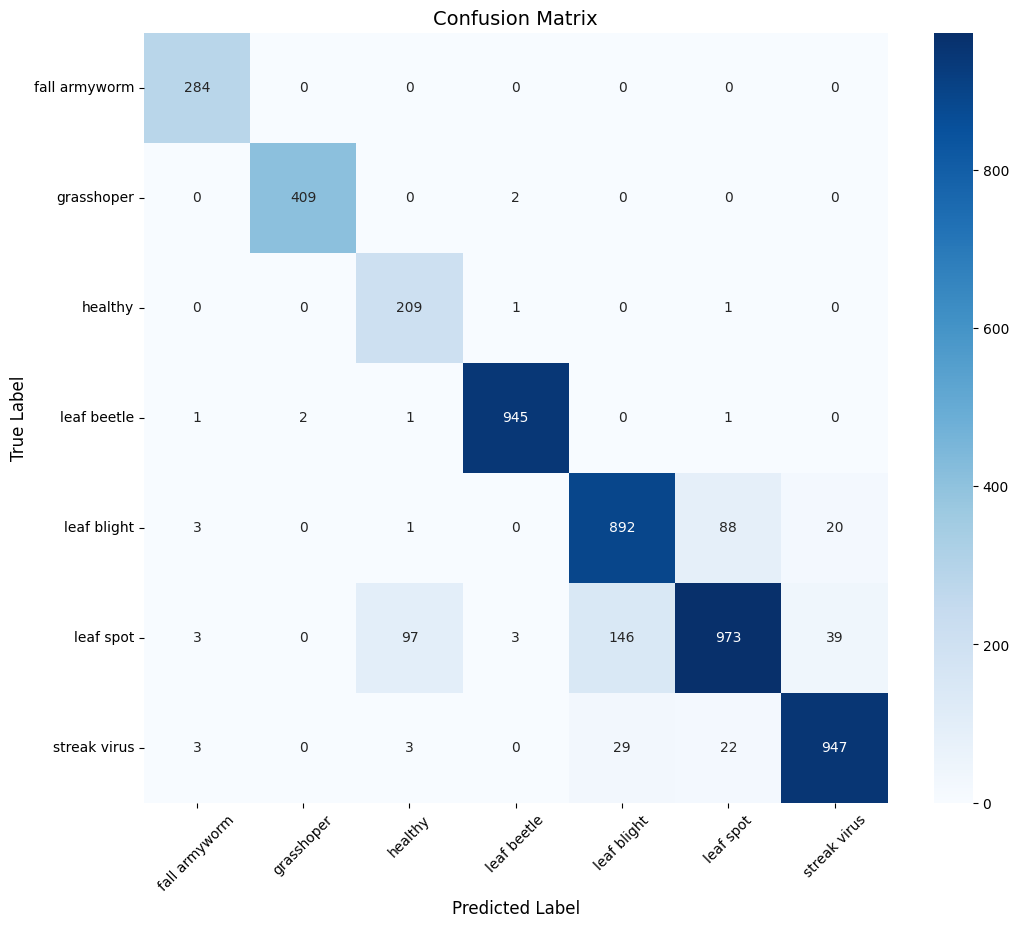

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Enable mixed precision training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Paths
base_path = "/kaggle/input/dataset-for-crop-pest-and-disease-detection/Dataset for Crop Pest and Disease Detection"
train_dir = os.path.join(base_path, "CCMT Dataset-Augmented/Maize/train_set")
test_dir = os.path.join(base_path, "CCMT Dataset-Augmented/Maize/test_set")

# Optimized Parameters
img_size = (256, 256)
batch_size = 40
epochs = 60

# Enhanced Augmentation - Maize-specific
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=40,
    fill_mode='reflect'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data Loaders
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Enhanced Class Weighting
class_weights = compute_class_weight('balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights = {i: weight*1.3 for i, weight in enumerate(class_weights)}

# Model Architecture with Attention
base_model = EfficientNetB4(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)

# Progressive Unfreezing Strategy
base_model.trainable = True
for layer in base_model.layers[:180]:
    layer.trainable = False

# Attention Mechanism
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Channel Attention (corrected dimensions)
attention = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
attention = Dropout(0.3)(attention)
attention = Dense(x.shape[-1], activation='sigmoid', kernel_regularizer=l2(1e-4))(attention)  # Match dimensions
x = Multiply()([x, attention])

# Enhanced Classifier Head
x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax', dtype='float32')(x)
model = Model(inputs=base_model.input, outputs=output)

# Advanced Learning Rate Schedule
def lr_schedule(epoch):
    if epoch < 20:
        return 5e-4
    elif epoch < 40:
        return 2e-4
    elif epoch < 50:
        return 1e-4
    else:
        return 5e-5

# Label Smoothing Cross Entropy (more stable than focal loss)
model.compile(
    optimizer=Adam(5e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Enhanced Callbacks
checkpoint = ModelCheckpoint(
    "maize_best_final.weights.h5",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

lr_scheduler = LearningRateScheduler(lr_schedule)

# Training
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data,
    callbacks=[checkpoint, early_stop, reduce_lr, lr_scheduler],
    class_weight=class_weights,
    verbose=1
)

# Evaluation
model.load_weights("maize_best_final.weights.h5")
loss, acc, precision, recall = model.evaluate(test_data, verbose=0)
print(f"\n✅ Maize Test Accuracy: {acc*100:.2f}%")
print(f"✅ Precision: {precision*100:.2f}%")
print(f"✅ Recall: {recall*100:.2f}%")

# Detailed Classification Report
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print("\nEnhanced Classification Report:")
print(classification_report(test_data.classes, y_pred, target_names=list(test_data.class_indices.keys())))

# Confusion Matrix Visualization
conf_mat = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', 
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys(),
            cmap='Blues')
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()